### Implementation of a STN 



In [1]:
import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad,jit,vmap
import tensorflow as tf #for dataset import
import matplotlib.pyplot as py
from keras.utils import to_categorical
import imageio

### Spatial Transformer Network Implementation (Jaderberg et al , 2015). 

Implementation from https://kevinzakka.github.io/2017/01/18/stn-part2/

In [2]:
w=28
h=28
x=np.linspace(-1,1,w)
y=np.linspace(-1,1,h)
xt,yt=np.meshgrid(x,y)
angle=0.9
one_temp= np.ones((w*h))
sampling_grid = np.vstack([xt.flatten(), yt.flatten(),one_temp])


In [3]:

def affine_transformation(input_img,affine,sampling_grid):
  
  transformed_grid=jnp.matmul(affine,sampling_grid)
  transformed_grid=transformed_grid.T
  x_s = transformed_grid[:, 0:1].squeeze() #take all x
  y_s = transformed_grid[:, 1:2].squeeze() #take all y
  x = ((x_s + 1.) * w) * 0.5 #final transformed x and y coordinates which contains non-integer x and y values (1.2 etc...)
  y = ((y_s + 1.) * h) * 0.5

  #bilinear interpolation
  # grab 4 nearest corner points for each (x_i, y_i) #to grab the nearest real pixel value assign value
  x0 = jnp.floor(x).astype(np.int32)
  x1 = x0 + 1
  y0 = jnp.floor(y).astype(np.int32)
  y1 = y0 + 1
  # make sure it's inside img range [0, H] or [0, W]
  x0 = jnp.clip(x0, 0, w-1)
  x1 = jnp.clip(x1, 0, w-1)
  y0 = jnp.clip(y0, 0, h-1)
  y1 = jnp.clip(y1, 0, h-1)

  # look up pixel values at corner coords 
  Ia = input_img[y0, x0]
  Ib = input_img[y1, x0]
  Ic = input_img[y0, x1]
  Id = input_img[y1, x1]

  # calculate deltas. 
  wa = (x1-x) * (y1-y)
  wb = (x1-x) * (y-y0)
  wc = (x-x0) * (y1-y)
  wd = (x-x0) * (y-y0)
  out = wa*Ia + wb*Ib + wc*Ic + wd*Id
  return out

### Main Network.
Localization + Grid Generator+ Sampling into one function called "localization"

In [4]:
def forward(image_input,params,bias,sampling_grid): 
  affine_layer=localization(image_input,params,bias,sampling_grid)
  t1=affine_transformation(image_input,affine_layer,sampling_grid) #param[0] is an affine grid, the output is a 784 image. 
  return t1


def localization(image_input,params,bias,sampling_grid): 
  #Network 1: Transpose Network : Takes image, outputs transpose matrix ie: [0,0,x],[0,0,y]
  fimage_input=image_input.flatten()
  local11 = jnp.dot(fimage_input,params[0].T) +bias[0]
  local11=jax.nn.relu(local11) 
  local12=jnp.dot(local11,params[1].T) +bias[1]  
  #SIN function set to 0.7 --> More stability? 
  local12 =jnp.sin(local12)*0.7 #to prevent out of bounds values? #keep values between 0, 1? #This is what SIREN uses. 
  transpose_affine =jnp.array([[0,0,local12[0]],[0,0,local12[1]]]) #
  affine_layer1=transpose_affine.reshape(2,3)


  #Network 2: Affine rotation: Takes image outputs rotation matrix ie:  [[cos(theta),-sin(theta),0],[sin(theta),cos(theta),0]]
  fimage_input=image_input.flatten()
  local21 = jnp.dot(fimage_input,params[2].T) +bias[2] 
  local21=jax.nn.relu(local21) 
  local22=jnp.dot(local21,params[3].T) +bias[3] 
  local22 = (local22*360) * (3.14/180) #convert values between [-1,1] to radians. 
  rotation_affine=jnp.array([[jnp.cos(local22[0]),-jnp.sin(local22[0]),0],[jnp.sin(local22[0]),jnp.cos(local22[0]),0]])
  affine_layer2=rotation_affine.reshape(2,3)


  #Network 3: Scaling Network: Takes image outputs scaling matrix (ie: [[x,0,0],[0,y,0]]) 
  fimage_input=image_input.flatten()
  local31 = jnp.dot(fimage_input,params[4].T) +bias[4] 
  local31=jax.nn.relu(local31) 
  local32=jnp.dot(local31,params[5].T) +bias[5]  
  #Sin scaled for stability?
  local32 = jnp.sin(local32)*0.5
  scaling_affine=jnp.array([[local32[0],0,0],[0,local32[1],0]]) 
  affine_layer3=scaling_affine.reshape(2,3)

  #final matrix
  affine_layer = (affine_layer1+affine_layer2+affine_layer3)
  return affine_layer


def MSE (input_image,target,params,bias,sampling_grid):
  pred=forward(input_image,params,bias,sampling_grid)
  temp=(target-pred)**2
  output=jnp.mean(temp,axis=0)
  return output

def update_params(gradient,dbias, params,bias ,lr=0.0001): 
  for i in range(len(params)): #iterate through the layer. 
    params[i]=params[i]-(lr*jnp.sum(gradient[i],axis=0))
    bias[i]=bias[i]-(lr*jnp.sum(dbias[i],axis=0))
  return params,bias

#My Subpar implementation of RMSProp 
#p_params stores the previous gradient of params
#p_bias stores previous gradient of bias 

def RMSProp (dparams,dbias,params,bias,p_params,p_bias,p_vp, p_vb,lr=0.1,rho=0.80,epsilon = 0.9 ): 
  v_tp=[]
  v_tb=[]
  #calculate adaptive learning rate.
  for i in range(len(params)): 
    #parameters
    v_tp.append(rho*p_vp[i] + (1-rho)* p_params[i]**2)
     #bias
    v_tb.append(rho*p_vb[i] + (1-rho)* p_bias[i]**2)
  for i in range(len(params)): #iterate through the layer. 
    params[i]=params[i]-((lr/(jnp.sqrt(v_tp[i])+epsilon)) * jnp.sum(dparams[i],axis=0))
    bias[i]=bias[i]-((lr/(jnp.sqrt(v_tb[i])+epsilon)) * jnp.sum(dbias[i],axis=0))
  return params,bias,v_tp,v_tb
  
gradient=grad(MSE,argnums=(2,3))


###Load dataset

In [5]:
(train_images,_),(_,_)=tf.keras.datasets.mnist.load_data()
train_images=train_images.reshape(60000,784)/255.0


###Choose the MNIST number you want the network to transform

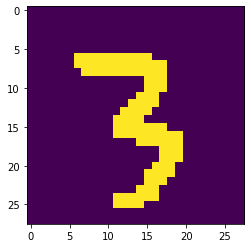

In [6]:
sample=44

base=train_images[sample]

base=base.flatten() 
for i in range(len(base)): 
  if base[i] >0: 
    base[i]=1
  
base=base.reshape(28,28)

py.imshow(base.reshape(28,28))



### Choose the MNIST number you want the network to fit to

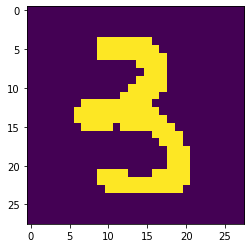

In [7]:
#CHOOSE SAMPLE BY MODIFYING NUMBER BELOW.
sample=1150 #1145

target=train_images[sample]
target=target.flatten() 
for i in range(len(target)): 
  if target[i] >0: 
    target[i]=1
  
target=target.reshape(28,28)
py.imshow(target.reshape(28,28))

target=target.flatten()


### Initalize Parameters

In [8]:
np.random.seed(1006)
param=[] 
param.append(np.random.randn(100,784)/10)#Params 1 and 2 is for transpose network 
param.append(np.random.randn(2,100)/10) 
param.append(np.random.randn(100,784)/10)#Params  3 and 4 is for the rotation network 
param.append(np.random.randn(1,100)/10) 
param.append(np.random.randn(100,784)/10)#Params 5 and 6 is for the scaling network
param.append(np.random.randn(2,100)/10) 
            
bias=[] 
bias.append(np.random.randn(100)/10)#Bias 1 and 2 is for transpose network 
bias.append(np.random.randn(2)/10)
bias.append(np.random.randn(100)/10)#Bias 3 and 4 is for transpose network
bias.append(np.random.randn(1)/10) 
bias.append(np.random.randn(100)/10)#Bias 5 and 6 is for transpose network.
bias.append(np.random.randn(2)/10) 



### Training loop

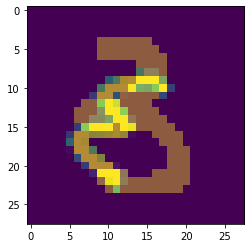

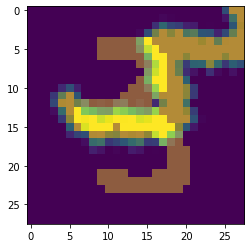

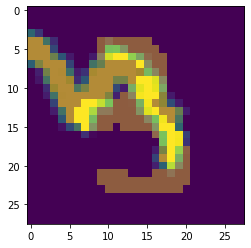

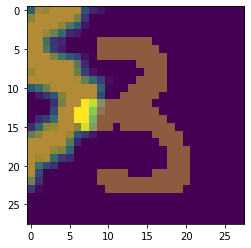

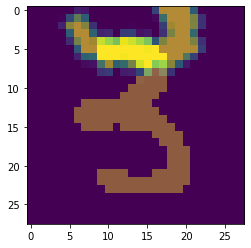

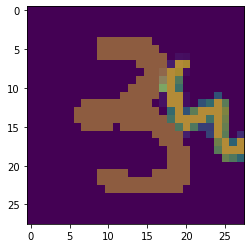

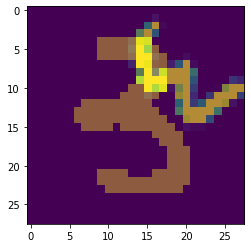

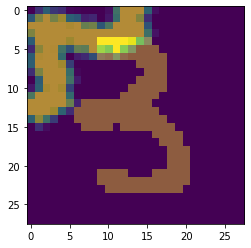

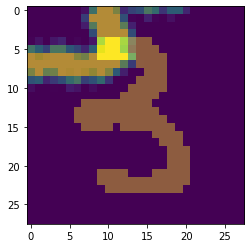

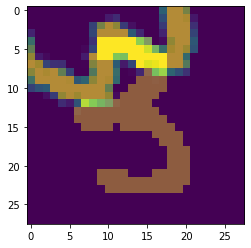

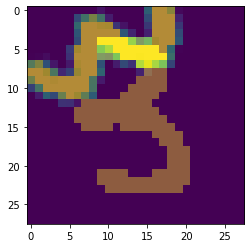

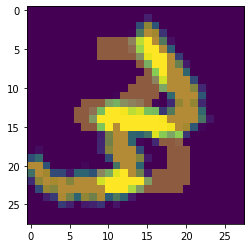

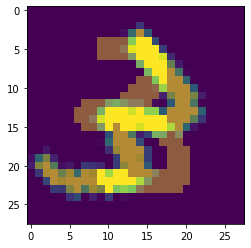

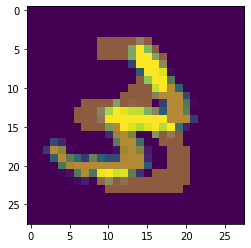

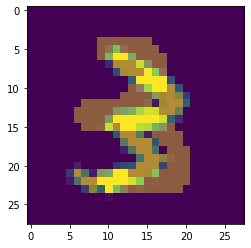

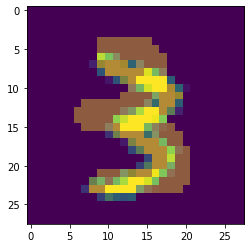

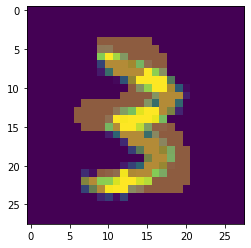

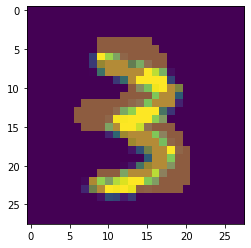

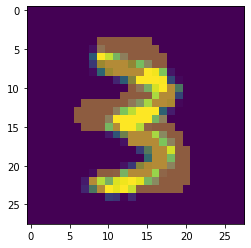

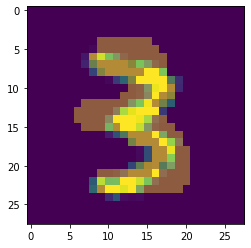

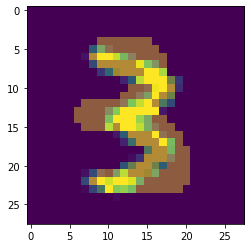

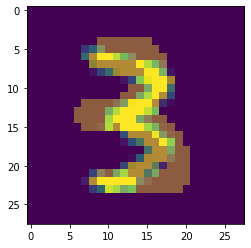

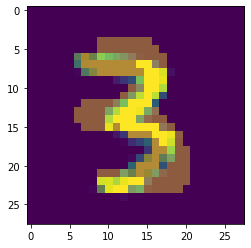

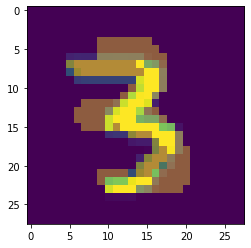

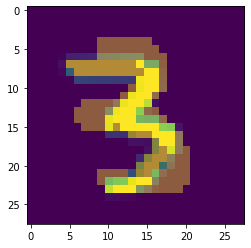

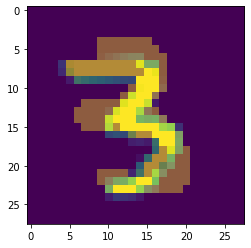

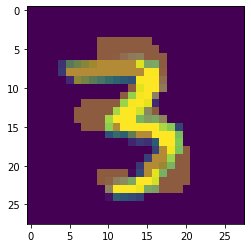

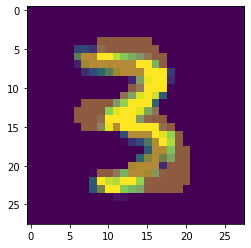

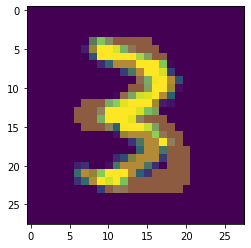

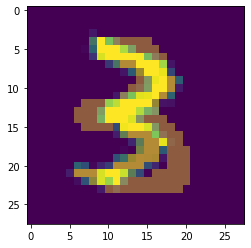

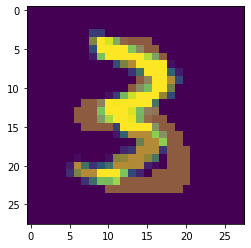

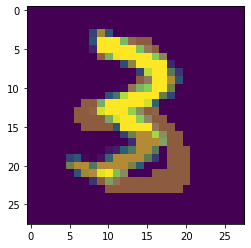

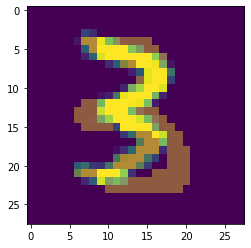

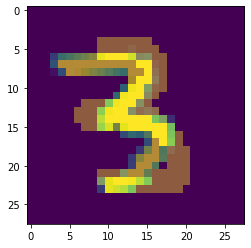

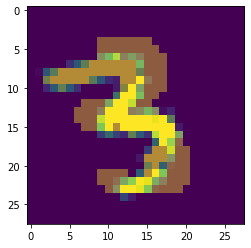

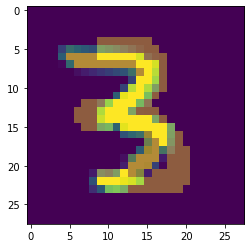

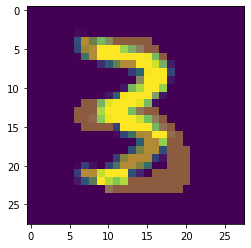

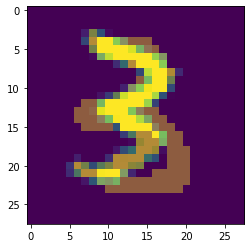

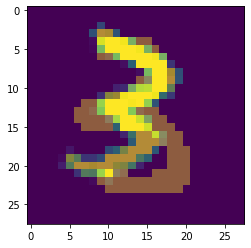

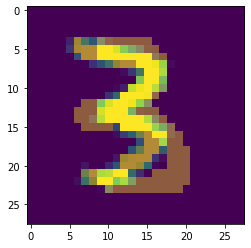

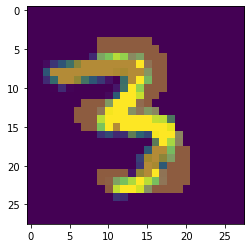

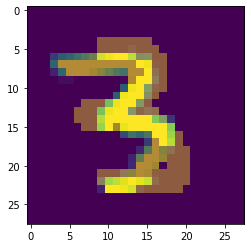

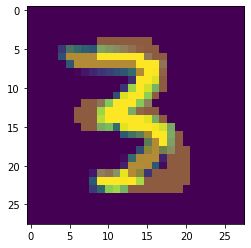

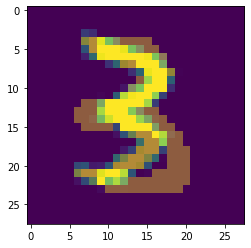

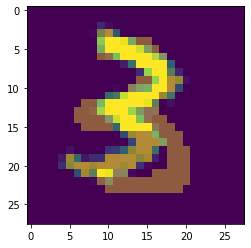

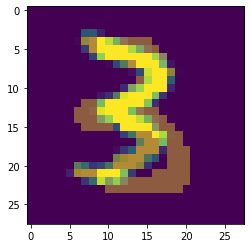

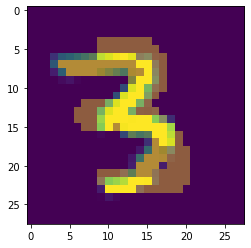

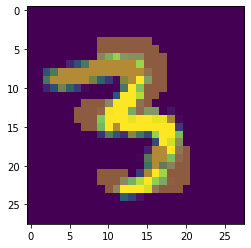

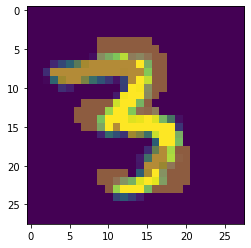

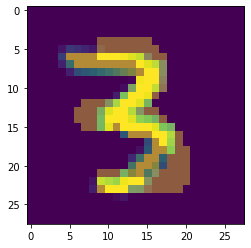

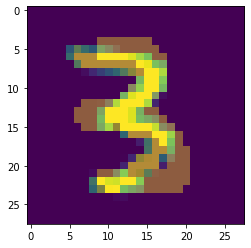

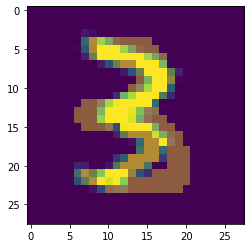

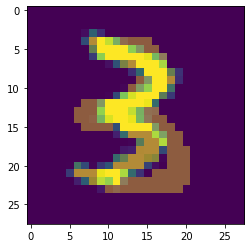

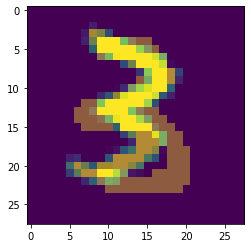

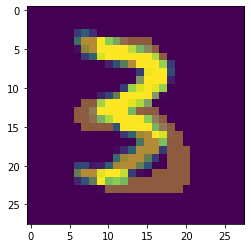

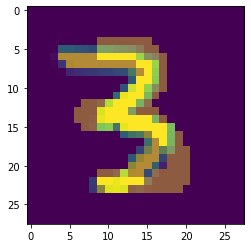

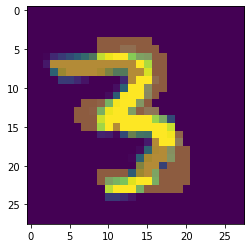

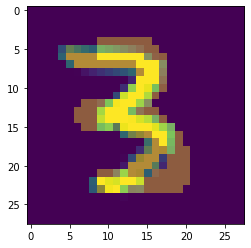

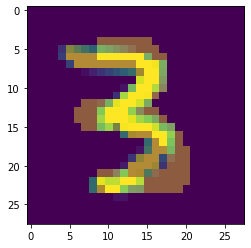

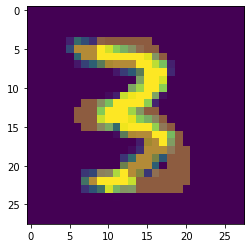

In [9]:
p_vp=jnp.zeros((4))
p_vb=jnp.zeros((4))
for epoch in range(0,60):
 
  for i in range(1): 
    
    dparam,dbias=(gradient)(base,target,param,bias,sampling_grid)
   
    if epoch ==0:  
      param,bias=jit(update_params)(dparam,dbias,param,bias,lr=0.1)
      p_params=dparam
      p_bias=dbias
     
    else:
      param,bias,p_vp,p_vb = RMSProp(p_params,p_bias,param,bias,p_params,p_bias,p_vp,p_vb,rho=0.85,lr=0.1)
      p_params=dparam
      p_bias=dbias
    
  new_affine=localization(base,param,bias,sampling_grid)
  new_image = affine_transformation(base,new_affine,sampling_grid)

  py.imshow(new_image.reshape(28,28))
  py.imshow(target.reshape(28,28),alpha=0.4)
  
  #UNCOMMENT IF YOU WANT TO STORE IMAGES.
  #filename= 'image ' + np.str(epoch)
  #py.savefig(filename)
  
  super=py.show()


  

In [10]:
#UNCOMMENT IF YOU WANT A GIF FILE.

#images=[]
#for i in range (60): 
  #filename = 'image ' + np.str(i) + '.png'
  #images.append (imageio.imread(filename))

#imageio.mimsave('movie 2.gif', images)
